In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))

## don't show warning
import warnings
warnings.filterwarnings('ignore')

## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

## import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from torch.nn import init
import torch.optim as optim

## for system
import glob
import os, sys
sys.path.append(os.path.expanduser("../../toolkits"))
import basicTools as bt
import Etranform as et
import mapTools.linear as mt
from importlib import reload

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## the data directory
datadir = os.path.realpath("../../data")

## the prefix and suffix for search 
filePref = f"{datadir}/" #"/MD-clst"
fileSuff = ".xtc"

## the input trajs
trajs = [x.replace(filePref, "").replace(fileSuff, "") 
         for x in sorted(glob.glob(f"{filePref}*{fileSuff}"))
         #if '000' in x
        ]

## output information
print("Find ", len(trajs), " trajectories in ", datadir)

Find  6  trajectories in  /home/ghzuo/data/gromacs/data.BBA/1fme/unfolding


In [3]:
## set the feature
feature = "dih"  #dih or dist

## The data per frames
skip = 1

### smooth
step    = 100
width   = 200
seg2vec = bt.segment.medoid

### similar metrix
similar = bt.dist.cosin

### evalute method
evalute = bt.evalute.cluster

# RMSD from Native Structure

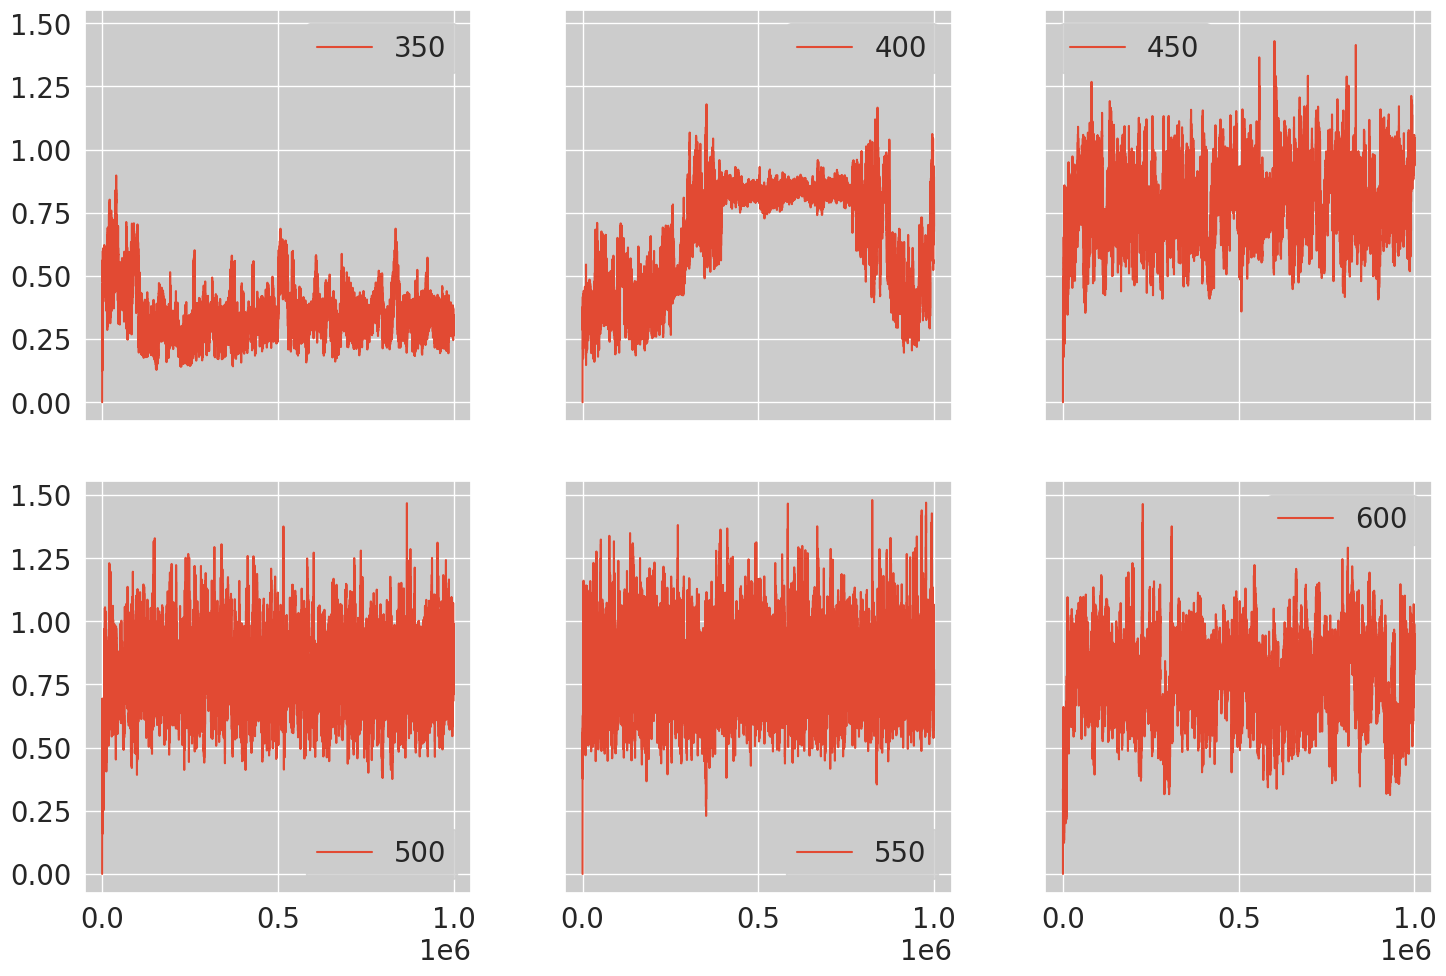

In [4]:
ncol = 3
nrow = (len(trajs) - 1) // ncol + 1
fig, axs = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(15,5*nrow))
fig.tight_layout()
for ax,i in zip(axs.reshape(axs.size),trajs):
    fn = "{:s}{:s}-CaRMS.xvg".format(filePref,i)
    rms = np.loadtxt(fn, comments=["@","#"]) 
    ax.plot(rms[:,0], rms[:,1], label="{:s}".format(i))
    ax.legend()

# Rescaling and Clustering

In [5]:
def testSC(n, Smat, Xs):
    cl = SpectralClustering(n_clusters=n, affinity='precomputed').fit_predict(Smat)
    return evalute(Xs, cl)

def tryCluster(Xv):
    Xs = seg2vec(Xv, step, width)
    Smat  = similar(Xs) 
    score = pd.DataFrame({'ncluster':np.arange(2,10)})
    score['score'] = score['ncluster'].apply(lambda n: testSC(n, Smat, Xs))
    idxPeak = score['score'].idxmax();
    return score.loc[idxPeak, :]

In [6]:
## read data from file
scores = {}
QMC = pd.DataFrame({'Trajectory Index':trajs, 
                    'Kappa':np.zeros(len(trajs)),
                    'Value':np.zeros(len(trajs))
                   }).set_index('Trajectory Index')
for trj in trajs:
    ### the structure data
    X = bt.feature.dih2X(f"{filePref}{trj}-rama.xvg", True) if feature == "dih" \
            else bt.feature.dist2X(f"{filePref}{trj}-CaDist.xvg", True) 

    # normaliztion
    X = np.array(X.loc[1::skip, :].reset_index(drop=True))

    ### read the energy
    eng = pd.DataFrame(np.loadtxt(f"{filePref}{trj}-potential.xvg", comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))
    E  = np.array(eng.loc[1::skip, 'energy'])
    
    ### do the scaling
    efft = et.Efft(X, E)
    xmap = mt.LinearRegress(efft)
    qmc = xmap.score()
    QMC.loc[trj,'Kappa'] = qmc['KappaMax']
    QMC.loc[trj,'Value'] = qmc['qmcMax']
    
    ## get score
    scores["raw", trj] = tryCluster(X)
    rescl = xmap.scale(qmc['KappaMax'])
    scores["scaled", trj] = tryCluster(rescl['X'])

## Evalute by Rescaling

<Axes: xlabel='Trajectory Index'>

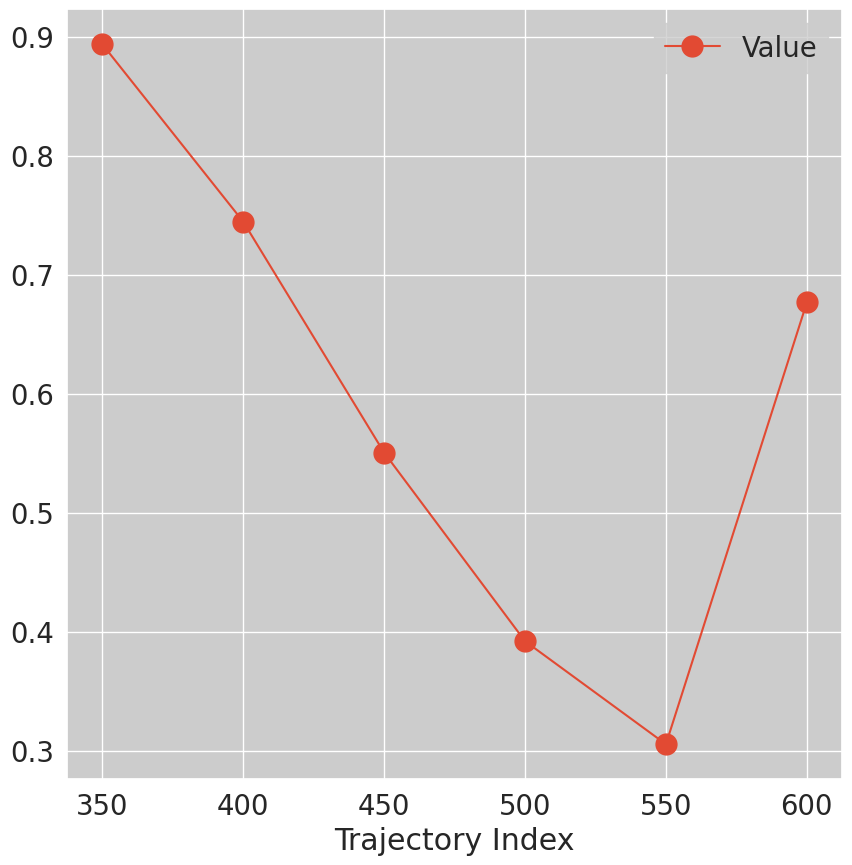

In [7]:
QMC.plot(y=["Value"], marker="o")

In [8]:
QMC

,Kappa,Value
Trajectory Index,,
350,2.0,0.893682
400,2.0,0.744607
450,2.0,0.550525
500,2.0,0.392068
550,2.0,0.305426
600,2.0,0.676722


## Score of Clustering

In [9]:
## get the table
result = pd.DataFrame(scores).T.reset_index().pivot(
            index='level_1',columns='level_0', 
            values=['ncluster', 'score'])
result.columns = ["ncls raw", "ncls scale", "score raw", "score scaled"]
result.index.set_names(['Trajectory Index'], inplace=True)  

<Axes: xlabel='Trajectory Index'>

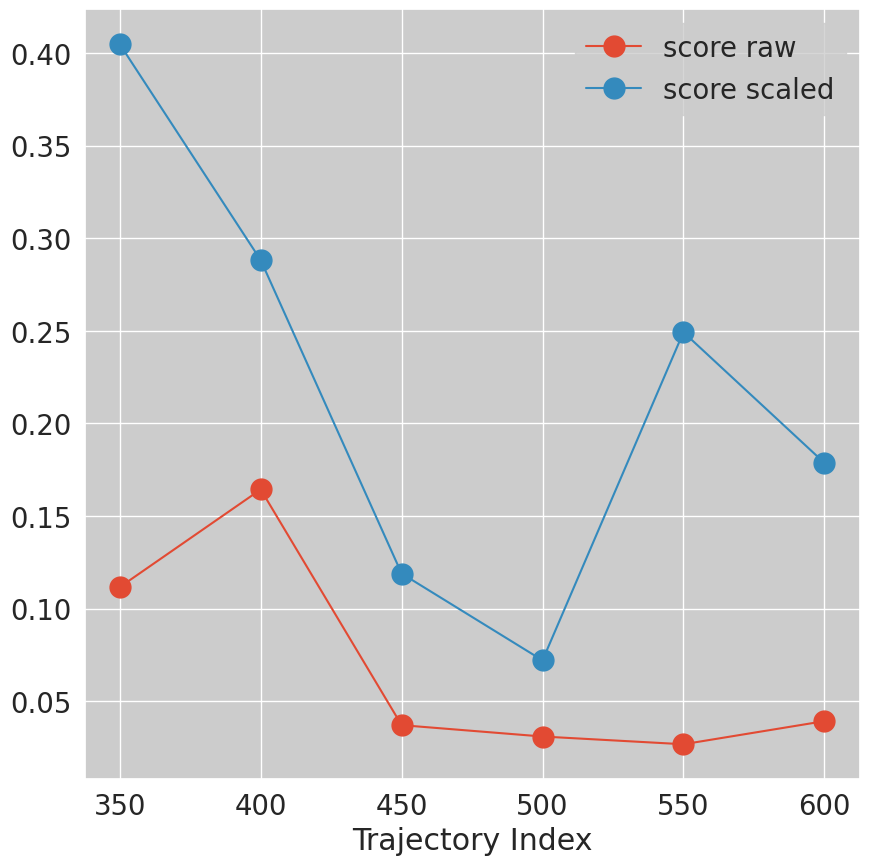

In [10]:
## plot data
result.plot(y=["score raw","score scaled"], marker="o")

In [11]:
result

,ncls raw,ncls scale,score raw,score scaled
Trajectory Index,,,,
350,4.0,2.0,0.111635,0.404767
400,3.0,9.0,0.164353,0.288191
450,9.0,2.0,0.037076,0.118955
500,2.0,2.0,0.030945,0.072075
550,2.0,2.0,0.026766,0.249275
600,9.0,2.0,0.039237,0.178720


In [12]:
## save current ipynb
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

In [13]:
## record output to pdf
#nbname = os.path.basename(app.sessions.get_state().get('current_session').get('path'))
nbname = "evaluateTraj.ipynb"
srcpath = %pwd
srcfile = f"{srcpath}/{nbname}"

!jupyter nbconvert --to pdf --no-input --log-level 40 \
    --output-dir {datadir} --output f"evaluateTraj-{feature}.pdf" \
    {srcfile}